# Across-Visits Testing with [glhmm toolbox](https://github.com/vidaurre/glhmm)

In this tutorial we explore the implementation of across-visits testing from the [glhmm toolbox](https://github.com/vidaurre/glhmm). 

Initially, we load a synthetic signal (```Y_data```) and proceed to fit a Hidden Markov Model (HMM) to the signal using the [glhmm toolbox](https://github.com/vidaurre/glhmm). After that, we decode the Viterbi path and use it as our (```X_data```).

In the real world scenarios, one would typically fit a Hidden Markov Model (HMM) to an actual dataset. However, for the sake of showing the concept of statistical testing, we just use synthetic data for both the independent variable (```X_data```) and the dependent variable (```Y_data```) for the ```across-visits``` test. 

While the simulation process requires some explanation, executing the test itself is straightforward—simply input the ```X_data``` and ```Y_data```, and define the specific ```method``` you wish to employ.

The function ```across-visits``` offers a range of statistical testing methods such as regression, correlation, one vs rest, and state pairs. Each of these methods is comprehensively described in the [Permutation testing tutorial - Across-Visits](#perm-intro). This tutorial serves as a guide to navigate through these testing methodologies and offer clarity on their application and interpretation.


## Table of Contents
1. [Load and prepare data](#load-data)
2. [Initialise and train HMM](#HMM-train)
    * [Decode Viterbi path](#vpath-decode)
    * [Visualize Viterbi path](#vpath-vis)
2. [Permutation testing tutorial - Across-Visits](#perm-intro)
    * [Regression](#perm-regression)
    * [Correlation](#perm-correlation)
    * [One vs rest](#perm-rest)
    * [State pairs](#perm-pairs)

### Import libraries
Let's start by importing the required libraries and modules.

In [1]:
# Importing libraries
import seaborn as sns
import matplotlib.pyplot as plt
import os
import numpy as np
import glhmm.glhmm as glhmm
from helperfunctions import plot_vpath
from permtest import generate_vpath_1D

### install necessary packages

In [2]:
# !pip install --user git+https://github.com/vidaurre/glhmm
# !pip install tdqm
# !pip install statsmodels

## 1.Load and prepare data <a id="load-data"></a>
Synthetic data are provided as example in the directory xxxxx. The file ```Y_data.npy``` contains synthetic timeseries. 

The data need to a specific structure when doing this tutorial. The array should be shaped as ((number of subjects/sessions * number of timepoints), number of features). This structure means that all subjects and/or sessions are concatenated along the first dimension, while the second dimension represents the number of features, such as parcels or channels.

In our example, we've generated timeseries for 5 subjects and 1 feature. Each subject's data spans 1,000 timepoints. Consequently, ```Y_data``` is shaped as [5000, 1], reflecting the concatenation of all subjects along the first dimension and the presence of 1 feature.

In [2]:
# Folder path
folder_path = "\\vpath_sim_data_50poly"

# Get the current directory
current_directory = os.getcwd()

# Load Y_data
data_file = '\\Y_data.npy'
file_path = os.path.join(current_directory + folder_path + data_file)
Y_data = np.load(file_path)

Let's try to see the shape of Y_data

In [3]:
print(f"Data dimension of Y_data: {Y_data.shape}")

Data dimension of Y_data: (5000, 1)


**Setting Timestamp Indices**\
Before initiating and training a Hidden Markov Model (HMM), it's necessary to define the indices in the concatenated timeseries that delineate the beginning and end of individual subjects or sessions. These indices should be organized in the shape [n_subjects, 2].

For instance, in our synthetic data scenario with 5 subjects and 1 feature, each subject exhibiting 1,000 timepoints, we utilize the function ```get_timestamp_indices``` to create the timestamp indices (```T_idx```). This resulting array will have the shape (5, 2), containing the indices that signify the start and end points for each subject's timeseries.

To run the function ```get_timestamp_indices``` we need to provide it with the inputs for the number of time points (```n_timepoints```) and the number of subjects (```n_subjects```). This will result with a a precise delineation of subject boundaries within the concatenated timeseries.


In [4]:
from helperfunctions import get_timestamp_indices
n_subjects = 5
n_timepoints = 1000
#Generate indices of the timestamps for each subject in the data.
T_idx =get_timestamp_indices(n_timepoints, n_subjects)

Let's look at how ```T_idx``` looks like. 

In [5]:
T_idx

array([[   0, 1000],
       [1000, 2000],
       [2000, 3000],
       [3000, 4000],
       [4000, 5000]])

## 2. Initialise and train HMM <a id="HMM-train"></a>
Now, let's initialize the ```hmm``` object and set the hyperparameters according to our modeling preferences.

In this case, we choose not to model an interaction between two sets of variables in the HMM states, so we set ```model_beta='no'```. For our estimation, we choose ```K=5``` states. If you wish to model a different number of states, simply adjust the value of K.

Our modeling approach involves representing states as Gaussian distributions with mean and a full covariance matrix. This means that each state is characterized by a mean amplitude and a functional connectivity pattern. To specify this configuration, set ```covtype='full'```. If you prefer not to model the mean, you can include ```model_mean='no'```. Optionally, you can check the hyperparameters to make sure that they correspond to how you want the model to be set up.


In [6]:
# 1. Create an instance of the glhmm class
K = 5 # number of states
hmm = glhmm.glhmm(model_beta='no', K=K, covtype='full')
print(hmm.hyperparameters)

{'K': 5, 'covtype': 'full', 'model_mean': 'state', 'model_beta': 'no', 'dirichlet_diag': 10, 'connectivity': None, 'Pstructure': array([[ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True]]), 'Pistructure': array([ True,  True,  True,  True,  True])}


**Train an HMM**\
Now, let's proceed to train the HMM using the loaded data (```Y_data```) and time indices (```T_idx```).

Since in this case, we are not modeling an interaction between two sets of timeseries but opting for a "classic" HMM, we set ```X=None```. For training, ```Y``` should represent the timeseries from which we aim to estimate states (```Y_data```), and indices should encompass the beginning and end indices of each subject (```T_idx```).



In [7]:
Gamma,Xi,FE = hmm.train(X=None, Y=Y_data, indices=T_idx)

Init repetition 1 free energy = 6994.758457162827
Init repetition 2 free energy = 7403.956257040908
Init repetition 3 free energy = 7171.912271802388
Init repetition 4 free energy = 7139.67406175126
Init repetition 5 free energy = 7292.682762034827
Best repetition: 1
Cycle 1 free energy = 7574.153628980145
Cycle 2 free energy = 6899.913668182613
Cycle 3, free energy = 6884.988472005515, relative change = 0.021656922184833113
Cycle 4, free energy = 6878.764907350705, relative change = 0.008949763580041258
Cycle 5, free energy = 6874.951664953424, relative change = 0.0054537066448149514
Cycle 6, free energy = 6871.139184251484, relative change = 0.005423047464425591
Cycle 7, free energy = 6868.282759886102, relative change = 0.004046667018640298
Cycle 8, free energy = 6867.292590588185, relative change = 0.0014007976732880296
Cycle 9, free energy = 6866.9909813384575, relative change = 0.00042650619448463467
Cycle 10, free energy = 6866.856849559713, relative change = 0.00018964002473550

**Decode Viterbi path**\
Now that our HMM is trained, we move on to the decoding phase to calculate the Viterbi path. The Viterbi path represents the most probable state sequence given an observation sequence and the trained HMM.



In [8]:
vpath = hmm.decode(X=None, Y=Y_data, indices=T_idx, viterbi=True)
vpath

array([[0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.]])

### Visualize Viterbi path
Now, let's visualize the distinct states in the Viterbi path from our trained Hidden Markov Model.

The plot provides a clear depiction of each time point assigned to a specific HMM state, with each state represented by a distinct color. This visualization allows us to easily discern the temporal distribution and transitions between different states.

In [ ]:
plot_vpath(vpath, figsize=(6,4))

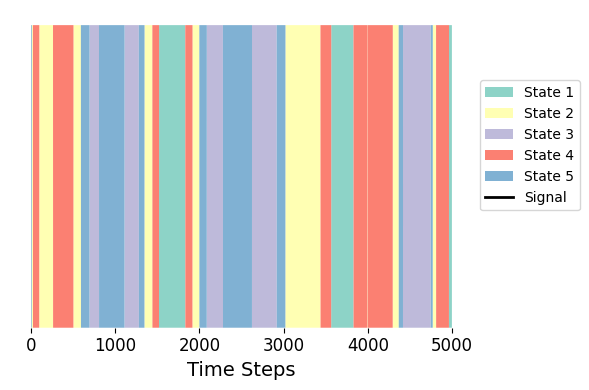

In [9]:
### Original figure

**Plot Viterbi path and discrete states**\
We can enhance our visualization by plotting the discrete states alongside the Viterbi path. Similar to our previous plot, this representation illustrates each time point assigned to a specific HMM state, with each state uniquely color-coded.

However, this updated plot introduces an additional layer. At the top of the figure, a secondary plot showcases each state's assignment to a specific value on the y-axis. This value corresponds to a particular HMM state. For instance, if we observe the value 5 on the y-axis, it aligns with the blue color, indicating that this value corresponds to state 5 in our HMM. This figure structure follows the same representation as figure 3D in our paper.

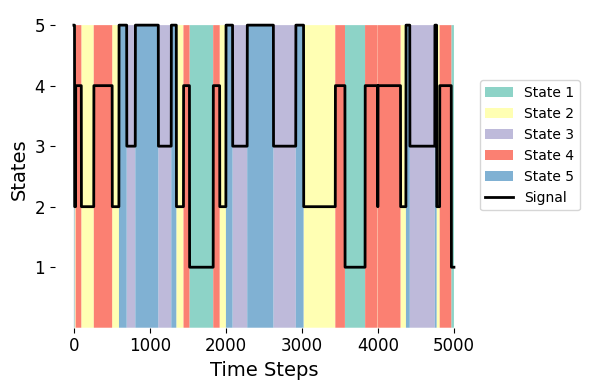

In [10]:
# Create a 1D array from the one-hot encoded Viterbi path data
vpath_1D=generate_vpath_1D(vpath)
# Convert the signal to be in a range from 0 to 1,
sig_state = vpath_1D/np.max(vpath_1D)
# Plot discrete states with the Viterbi path
plot_vpath(vpath,sig_state, yticks=True, figsize=(6,4), ylabel="States")

**Plot Viterbi path and real signal**\
Finally, we can further improve our visualization by plotting the real signal (```Y_data```) alongside the Viterbi path (```X_data```). This representation maintains the color-coded illustration of each time point assigned to a specific HMM state.
To create this plot, it's necessary to normalize the data, ensuring it ranges from 0 to 1 to align with the values of ```vpath```. It's crucial to note that this normalization is only for visualization purposes, which allow us to overlay the real signal with the Viterbi path and gain insights into how well the model captures the underlying dynamics.

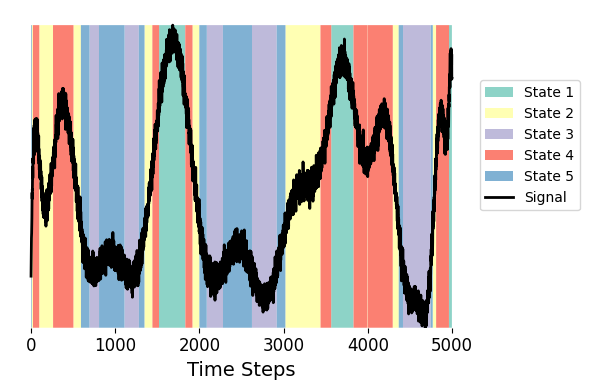

In [11]:
# Normalize the Y_data to the range [0, 1]
min_value = np.min(Y_data)
max_value = np.max(Y_data)
normalized_Y_data = ((Y_data - min_value) / (max_value - min_value))

# Plot vpath and Y_data
plot_vpath(vpath,normalized_Y_data, figsize=(6,4))

Let's delve into the values assigned to each state. To achieve this, we calculate the average of the values associated with each state.

This brief analysis provides insights into the typical or central values characterizing each state. By examining these averages, we gain a clearer understanding of the distinctive characteristics and patterns represented by the different states in our HMM.



In [12]:
val_state =[np.mean(Y_data[vpath_1D == i+1]) for i in range(K) ]
val_state

[4.912042797300882,
 -0.05858422375450776,
 -3.795696791047377,
 2.352225972831181,
 -2.5030418147224505]

The above figure shows an relation between the simulated Viterbi path (```X_data```) and the simulated behavioral measurements (```Y_data```). Notably, a closer examination of the variable ```val_state``` unveils distinct values assigned to each specific state: 

* State 1 (green) aligns with highest value 
* State 2 (yellow) corresponds to values in the middle, close to 0. 
* State 3 (purple) corresponds to the lowest negative values.
* States 4 (red) and State 5 (blue) are values that fall between the extremes values. 
This gives us a perspective on the behavioral dynamics across different states on our signal.

## 2. Permutation testing tutorial - Across-Visits <a id="perm-intro"></a>
As we transition to the next phase of this tutorial, we will learn how to apply the ```across_visits``` function to uncover relationships between HMM state time courses (X_data) and a continuously measured variable (Y_data) using permutation testing.

**Permutation testing**\
 Permutation testing is a non-parametric resampling technique that assesses statistical significance without assuming any data distribution. By randomly reshuffling measured data, it generates a null distribution, which can be used to test the null hypothesis — that there is no difference or relationship between variables of interest to be tested

### Across visits - Regression <a id="perm-regression"></a>

In regression analysis, we are trying to explain the relationships between predictor variables (```X_data```), such as the Viterbi path, and the response variable or signal (```Y_data```).

**Understanding Regression:**\
The objective is to discern the factors contributing to changes in signal values over time. Specifically, by examining the amount of explained variance, it can be used to analyze whether the Viterbi path, characterized by different states, plays a significant role in explaining the observed variability in signal values over time.

**Permutation Test for Explained Variance:**\
The permutation test for explained variance is a useful method to assess the statistical significance of relationships between the Viterbi path (```X_data```) and the signal (```Y_data```). A significant result implies that specific states in the Viterbi path contribute significantly to explaining why signal values vary over time. A non-significant result, on the other hand, suggests that the observed relationship can be attributed to random chance, implying that the Viterbi path may not play a significant role in accounting for the signal's variability.

**Explore data**\
First, let us look at the data that we are interested in:

In [14]:
print(f"Data dimension of viterbi path: {vpath.shape}")
print(f"Data dimension of data_signal: {Y_data.shape}")

Data dimension of viterbi path: (5000, 5)
Data dimension of data_signal: (5000, 1)


In this example, the Viterbi path (```X_data```) is a 5000x4 matrix, representing discrete states for each time point based on a simulated path. Each state is one-hot encoded as a binary vector. The corresponding simulated signal, represented as a 5000x1 array (```Y_data```), is a continuous variable.\
Running the ```across_visits``` function requires providing inputs of ```X_data``` and ```Y_data```, in this case with the number of states defined as four (n_states = 4). To initiate regression-based permutation testing, set ```method="regression"```.\
For a deeper look at the function look at the documentation.


In [15]:
from permtest import * # This function should just be in the GLHMM package
# Set the parameters for across_visits testing
method = "regression"
Nperm = 1000 # Number of permutations (default = 1000)
test_statistic_option=True
n_states = 5

result  =across_visits(vpath, Y_data, method=method,Nperm=Nperm,test_statistic_option=test_statistic_option, n_states=n_states)

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:09<00:00, 104.87it/s]


We can now examine the local ```result``` variable.

In [16]:
result

{'pval': array([0.77922078, 0.41658342, 0.80919081, 0.57842158, 0.60839161]),
 'corr_coef': array([0., 0., 0., 0., 0.]),
 'test_statistic': array([[20.42115966, 31.23986977, 26.89329772, 32.30695788, 30.50919142],
        [20.40866167, 35.05424597, 31.62771936, 21.49684978, 41.06155747],
        [ 7.1202963 , 35.89502959, 32.05782478, 29.35198584, 40.54168171],
        ...,
        [13.17434479, 37.56309537, 34.81319131, 37.12081903, 27.91297451],
        [31.16714508, 24.08896138, 33.76443416, 32.0764813 , 32.66434157],
        [11.40959614, 29.7747041 , 32.82516745, 33.22378719, 37.28371936]]),
 'pval_list': array([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]]),
 'test_type': 'across_visits',
 'method': 'regression'}

What we can see here is that ```result``` is a dictionary that contains the output of a statistical analysis applied using the specified ```method``` and ```test type```. 

Let us break it down:\ 

* ```pval```: This array holds the p-values resulting from the permutation test. Each value corresponds to a specific state.

* ```corr_coef```: Currently an empty list. It is intended to store correlation coefficients if correlation is involved in the analysis. In this case, the correlation coefficients are not calculated when we have set ```method="regression"```. 

* ```test_statistic```: Currently an empty list. This list could can store the test statistics associated with the permutation test. It provides additional information about the permutation distribution that is used to calculate the p-values. The output will exported if we set ```test_statistic_option=True```

* ```pval_list```: This list is currently empty. It stores the p-values concurrently calculated with correlation coefficients when ```method = "correlation_com"``` using the [scipy.stats.pearsonr](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearsonr.html) module.
Note: ```"correlation_com"``` stands for correlation combined and provides both the statistical significance of Pearson's correlation coefficient and a 2-tailed p-value. The output is exported when ```method = "correlation_com"``` and ```test_statistic_option=True```

* ```test_type```: Indicates the type of permutation test performed. In this case, it is ```across_visits```.

* ```method```: Specifies the method employed in the analysis. Here, it is ```'regression'```, indicating that the analysis is conducted using regression-based permutation testing.

**Visualization of results**\
Now that we have performed our test, we can then visualize the p-value array.\
We will import the function ```plot_heatmap``` from module ```helperfunctions.py```

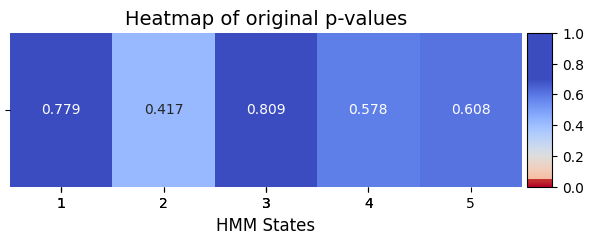

In [18]:
from helperfunctions import plot_heatmap
# Plot p-values
plot_heatmap(result["pval"],method, title_text ="Heatmap of original p-values",figsize=(7, 2), xlabel="HMM States", ylabel="", alpha=0.05)

**Conclusion - Regression**\
The permutation test for explained variance indicated that there is insufficient evidence to reject the null hypothesis for any of the HMM states. This suggests that, based on the statistical analysis, there is no statistically significant relationship between the various states in the Viterbi path and the temporal variability observed in the signal (```Y_data```). It's important to note that this outcome may be influenced by the challenging nature of fitting the data using regression methods.

### Across visits - Correlation <a id="perm-correlation"></a>
In correlation analysis, we are interested in understanding the intricate relationships between variables, specifically the Viterbi path (```X_data```) and the response variable or signal (```Y_data```).\
The aim is to explore the strength and direction of the relationship between the discrete states in the Viterbi path and the observed variability in continuous signal values over time.\
Utilizing the permutation test for correlation, we can assess the statistical significance of associations between the Viterbi path (```X_data```) and the signal (```Y_data```). A significant result indicates that specific states in the Viterbi path significantly contribute to the observed variations in signal values over time. Conversely, a non-significant result suggests that the relationship observed might be attributed to random chance, and the Viterbi path may not significantly influence the variability in the signal.

Like shown earlier, to execute the ```across_visits``` function successfully, you need to provide inputs in the form of ```X_data``` and ```Y_data```. Here the desired number of states is specified as four (n_states = 4). The function employs correlation-based permutation testing, which is achieved by configuring the method parameter as ```correlation_com```. Note that by selecting  ```correlation_com```, the function returns both the correlation coefficients matrix and the p-value matrix, whereas opting for ```correlation``` will only return the correlation coefficients matrix.
Additionally, we also set ```test_statistic_option=True``` to enable the export of the permutation distribution. 



In [19]:
# Set the parameters for across_visits testing
method = "correlation_com"
Nperm = 1000
n_states = 5
test_statistic_option=True

result  =across_visits(vpath, Y_data, method=method,Nperm=Nperm,test_statistic_option=test_statistic_option, n_states=n_states)

100%|██████████| 1000/1000 [00:12<00:00, 78.87it/s]


We can now examine the local ```result``` variable.

In [20]:
result

{'pval': array([0.00799201, 0.91208791, 0.00699301, 0.00999001, 0.04295704]),
 'corr_coef': array([0.002997  , 0.91208791, 0.000999  , 0.00999001, 0.04295704]),
 'test_statistic': array([[0.63053061, 0.02544851, 0.62533888, 0.48084955, 0.39815568],
        [0.06697349, 0.35520852, 0.06735979, 0.06859986, 0.30418699],
        [0.6305807 , 0.13777417, 0.27600714, 0.07683442, 0.01741416],
        ...,
        [0.42212623, 0.13160492, 0.17345147, 0.06421692, 0.27925764],
        [0.37345407, 0.13226651, 0.14842278, 0.08668714, 0.2017652 ],
        [0.08619246, 0.12014241, 0.01404521, 0.24633618, 0.33601478]]),
 'pval_list': array([[0.00000000e+000, 7.19675890e-002, 0.00000000e+000,
         9.88221808e-288, 1.33723725e-189],
        [2.13845533e-006, 1.32905190e-148, 1.86729345e-006,
         1.20235219e-006, 1.55496854e-107],
        [0.00000000e+000, 1.28837753e-022, 4.10613312e-088,
         5.33711015e-008, 2.18265869e-001],
        ...,
        [2.75250727e-215, 9.25751077e-021, 4.545

Now that we have the permutation distribution ['test_statistic] as we can see, it is because we set ```test_statistic_option=True```

**Visualization of results**\
Now that we have performed our test, we can then visualize the p-value array.
We will import the function ```plot_heatmap```, ```plot_scatter_with_labels``` and ```plot_histograms``` from module ```helperfunctions.py```

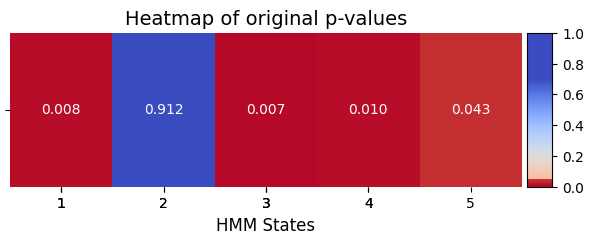

In [21]:
from helperfunctions import plot_heatmap,plot_scatter_with_labels,plot_histograms
# Plot p-values
plot_heatmap(result["pval"],method, title_text ="Heatmap of original p-values",figsize=(7, 2), xlabel="HMM States", ylabel="", alpha=0.05)

**Multiple Comparison**\
To be sure there is no type 1 error, we can apply the Benjamini/Hochberg to control the False Discovery Rate

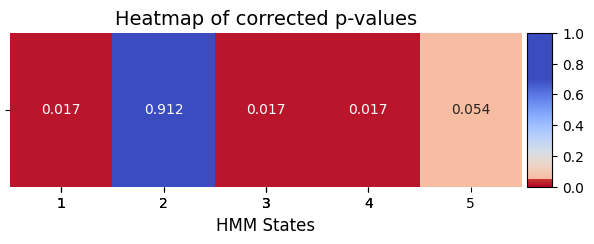

In [23]:
pval_corrected, rejected_corrected =pval_test(result["pval"], method='fdr_bh')
# Plot p-values
plot_heatmap(pval_corrected,method, title_text ="Heatmap of corrected p-values",figsize=(7, 2), xlabel="HMM States", ylabel="")

Instead of using a heatmap, we can also visualize the results with a scatter plot

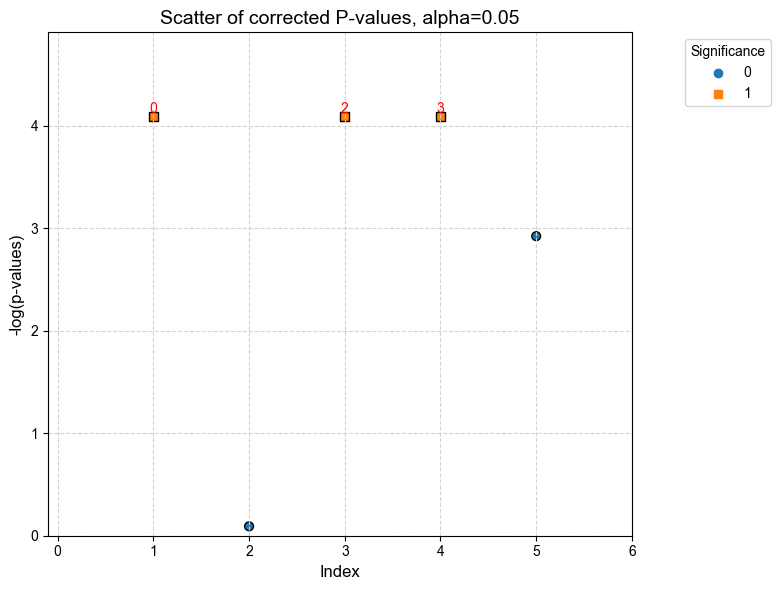

In [25]:
# Set the threshold of alpha to be 0.05
alpha=0.05
title_text = f"Scatter of corrected P-values, alpha={alpha}"
plot_scatter_with_labels(pval_corrected,alpha=alpha ,xlim_start=-0.1,ylim_start=0, title_text=title_text,)

**Plot permutation distribution**\
Presented here are the test statistics(```result["test_statistic"]```) of our permutation distributions for different states.
The red line shows the observed statistic, while the datapoints of the histogram represent the permutation distribution

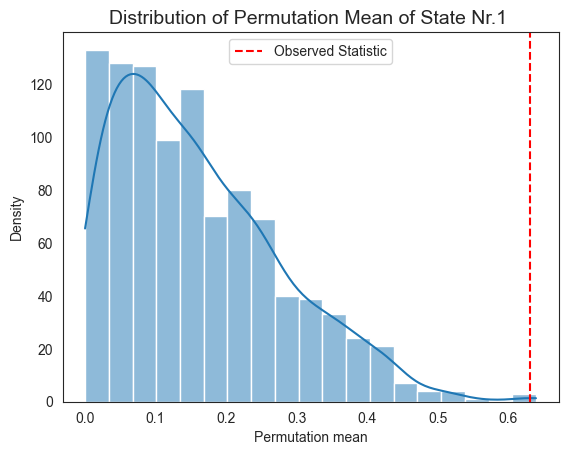

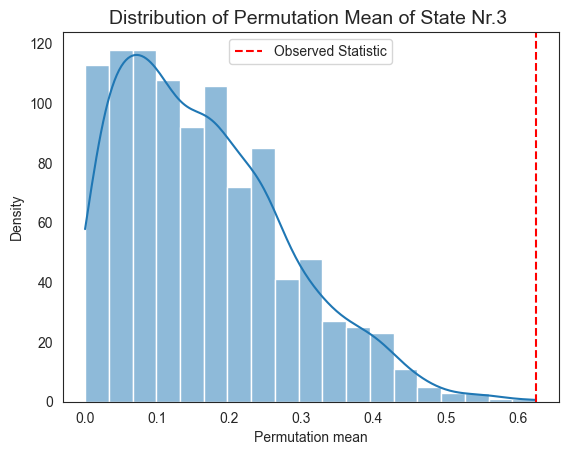

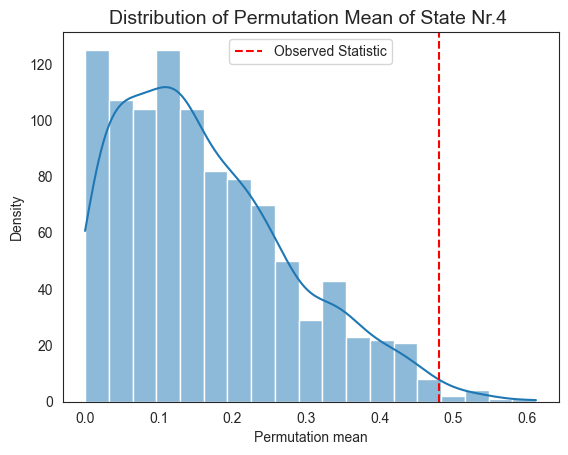

In [26]:
# Plot test statistics for pvals
significant_timestamp_position = np.where(pval_corrected < alpha)
for i in significant_timestamp_position[0]:
    plot_histograms(result["test_statistic"][:,i],title_text=f"Distribution of Permutation Mean of State Nr.{i+1} ")

### Conclusion - Correlation
The p-value array reveals a significant result for states 1, 3 and 4 while the state 2 and 5 do not exhibit statistical significance. This outcome suggests that the discrete states (1, 3 and 4) of the Viterbi path (```X_data```) play a meaningful role in explaining variations in the signal (```Y_data```).
Considering the signal characteristics, where the highest peak corresponds to state 1, the lowest peak to state 3, and the second-highest to state 4 this alignment reinforces the significance observed. 

It suggests that the distinct states, especially those with extreme signal values have a significant impact in shaping the variability of the signal.
 
Conversely, the lack of significance for states 2 and 5 implies that their influence may be more nuanced or less pronounced in explaining the observed variations in the signal.


## 8. Across visits - One vs rest <a id="perm-rest"></a>
In the permutation test comparing one state against the rest (one vs rest), we analyze the mean signal difference between a specific state (e.g., state 1) and the combined influence of the other states.
This approach assesses whether a particular state significantly differs from the collective impact of the remaining states in shaping signal values over time. In other words, the permutation test for mean difference allows us to discern if the observed variations in the signal (```Y_data```) are statistically significant for a specific state compared to the aggregate effect of the other states. A significant result suggests that the distinctive characteristics of that particular state contribute significantly to the observed variations in the signal. Conversely, a non-significant result implies that the observed difference may be attributed to random chance, indicating that the specific state might not play a substantial role in accounting for the variability in the signal compared to the rest.

This test can help identify physiological states that significantly differ from the combined influence of other states. Consequently, it proves valuable in understanding the specific impact of a particular physiological state on a measured variable. For instance, consider a study on heart rate variability across different states of arousal; this test has the potential to highlight states that distinctly influence heart rate.

In [29]:
from permtest import * # This function should just be in the GLHMM package
# Set the parameters for across_visits testing
method = "one_vs_rest"
Nperm = 1000
test_statistic_option=True
n_states = 5

result  =across_visits(vpath, Y_data, method=method,Nperm=Nperm,test_statistic_option=test_statistic_option, n_states=n_states)

100%|██████████| 1000/1000 [00:08<00:00, 111.54it/s]


**Visualization of results**\
Now that we have performed our test, we can then visualize the p-value array.
We will plot the p-values using the function ```plot_heatmap```

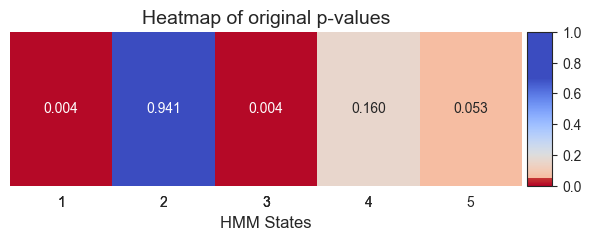

In [33]:
from helperfunctions import plot_heatmap
# Plot p-values
plot_heatmap(result["pval"],method, title_text ="Heatmap of original p-values",figsize=(7, 2), xlabel="HMM States", ylabel="", alpha=0.05)

**Multiple Comparison**\
Applying p-value correction using Bonferroni to take into account the risk of type 1 errors (false positive) due to multiple testing.

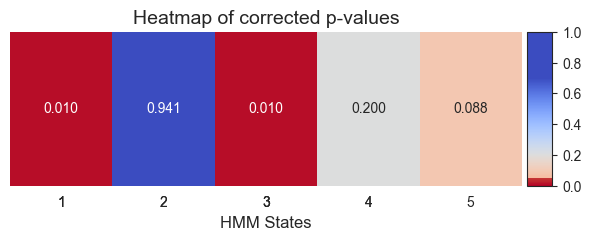

In [32]:
pval_corrected, rejected_corrected =pval_test(result["pval"], method='bonferroni')
# Plot p-values
plot_heatmap(pval_corrected,method, title_text ="Heatmap of corrected p-values",figsize=(7, 2), xlabel="HMM States", ylabel="")

### Conclusion - One vs rest
What it shows here is that the p-values that are signigicant (state 1 and 3) different correspond to the states with the highest and lowest values in the signal (```Y_data```). In the context of the ```"one vs rest"``` comparison, where each state is compared against the rest combined, a significant p-value indicates that the mean signal difference for that specific state is statistically different from the combined impact of the other states. Therefore, the highest and lowest p-values suggest that these two states significantly contribute to the observed variations in the signal, indicating their distinctive impact compared to the rest of the states.

## 9. Across visits - State pairs <a id="perm-pairs"></a>
In the permutation test comparing state pairs, we analyze the mean signal difference between different pairs of states (e.g., state 1 vs. state 2, state 1 vs. state 3, etc.).
This procedure studies whether the mean signal difference between specific state pairs is statistically significant. 

A significant result for a specific state pair implies that the mean signal difference between those states affects the observed variations in the signal. Conversely, a non-significant result suggests that the observed difference between those specific states might not play a substantial role in explaining the variability in the signal.
This can be useful when examining how physiological signals change during transitions between different states. For example, in studies on pain response, comparing mean differences between baseline and stress-induced states can provide insights into the physiological dynamics during transitions.

In [35]:
from permtest import * # This function should just be in the GLHMM package
# Set the parameters for across_visits testing
method = "state_pairs"
Nperm = 1000
test_statistic_option=True
n_states = 5

result  =across_visits(vpath, Y_data, method=method,Nperm=Nperm,test_statistic_option=test_statistic_option, n_states=n_states)

Pairwise comparisons: 100%|██████████| 10/10 [02:29<00:00, 14.91s/it]


**Visualization of results**\
Now that we have performed our test, we can then visualize the p-value array.
We will plot the p-values using the function ```plot_heatmap```

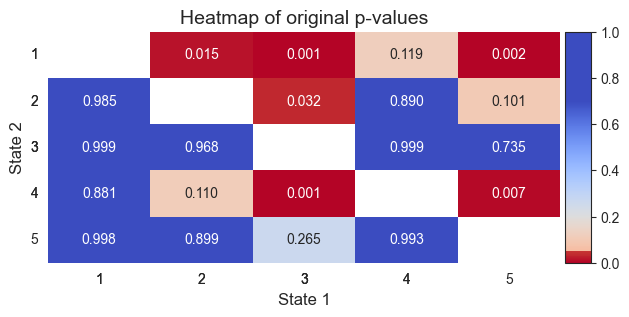

In [36]:
from helperfunctions import plot_heatmap,plot_scatter_with_labels,plot_histograms
# Plot p-values# Plot p-values
plot_heatmap(result["pval"],method, title_text ="Heatmap of original p-values",figsize=(7, 3), xlabel="State 1", ylabel="State 2", alpha=0.05, none_diagonal=True)

**Interpret the p-value matrix**\
The matrix has a shape of (number of states by number of states), and the values below the diagonal (lower-left) represent comparisons where the lower state number is less than the higher state number. Values above the diagonal (upper-right) represent comparisons where the lower state number is greater than the higher state number.

**Multiple Comparison**\
Now we can apply p-value correction using Bonferroni to control the risk of type 1 error (false positive).

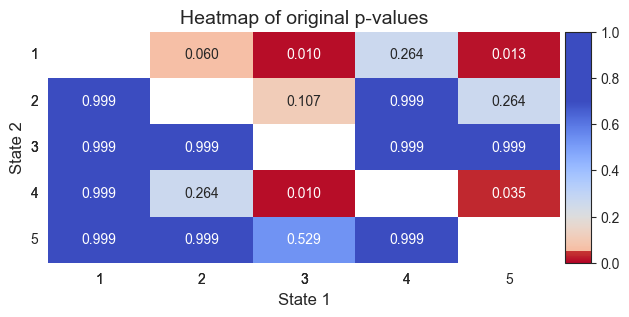

In [37]:
pval_corrected, rejected_corrected =pval_test(result["pval"], method='bonferroni')
# Plot p-values# Plot p-values
plot_heatmap(pval_corrected,method, title_text ="Heatmap of original p-values",figsize=(7, 3), xlabel="State 1", ylabel="State 2", alpha=0.05, none_diagonal=True)

In [39]:
val_state


[4.912042797300882,
 -0.05858422375450776,
 -3.795696791047377,
 2.352225972831181,
 -2.5030418147224505]

### Conclusion - state pairs
In the p-value matrix obtained from the permutation test for state pairs, where all values are negative except for the pairs 3 vs. 4, 3 vs. 1, 5 vs. 4, and 5 vs. 1, we can interpret that the mean signal differences for these specific state pairs are statistically significant. Notably, state 1, being the highest value, suggests a significant difference when compared with states 3 and 5. State 3, being the lowest value, indicates a significant difference when compared with states 4 and 1. States 4 and 5, falling in between, also show a significant mean signal difference when paired with each other and with states 3 and 1, respectively. 
This suggests that these specific state pairs play a substantial role in explaining the variability in the signal, and this could potentially provide valuable insights into how physiological signals change during transitions between different states, e.g. pain response studies.


### Save variables

In [41]:
import os
# Create folder if it doesn't exist
def create_folder_if_not_exists(folder_path):
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
        print(f"Folder created: {folder_path}")
    else:
        print(f"Folder already exists: {folder_path}")

# Example usage
folder_path = "vpath_11-12-2022"
create_folder_if_not_exists(folder_path)

# Get the current directory
current_directory = os.getcwd()
# Specify the folder path and name
folder_save = f"\\{folder_path}"

##################### Save variables #################
# Save vpath
data_file = '\\vpath.npy'
file_path = os.path.join(current_directory+folder_save+data_file)
np.save(file_path, vpath)

# Save normalized_y_fit
data_file = '\\normalized_Y_data.npy'
file_path = os.path.join(current_directory+folder_save+data_file)
np.save(file_path, normalized_Y_data)

# Save com_signal - signal + noise
data_file = '\\Y_data.npy'
file_path = os.path.join(current_directory+folder_save+data_file)
np.save(file_path, Y_data)


# Save diversified_values - random values assigned to each sate
data_file = '\\val_state.npy'
file_path = os.path.join(current_directory+folder_save+data_file)
np.save(file_path, val_state)



Folder already exists: vpath_11-12-2022


### Save HMM object

In [42]:

import pickle
# Save model
# Specify the file path where you want to save the data
pickle_file = '\\glhmm_instance.pickle'
file_path = os.path.join(current_directory+folder_save+pickle_file)   

# Open the file in binary write mode
with open(file_path, 'wb') as file:
    # Use pickle.dump to save the data to the file
    pickle.dump(hmm, file)

print("Data saved to", file_path)

# # Open the file in binary read mode
# with open(file_path, 'rb') as file:
#     # Use pickle.load to load the data from the file
#     loaded_data = pickle.load(file)

# print("Loaded data:", loaded_data)

Data saved to c:\Users\au323479\Desktop\Permutation_test\GLHMM\Permutation_test_13-11_include_viterbi_path_permutation_matrix\vpath_11-12-2022\glhmm_instance.pickle
